In [2]:
import pandas as pd
import os

spread_df = pd.read_csv('/Users/jeremy_gp/Documents/GitHub/SummerIndependentProject/tickData/spreadData/EHF_spread.csv', index_col=0)
# change the column name 0 to spread
spread_df.columns = ['spread']
spread_df.index = pd.to_datetime(spread_df.index)
spread_df

,spread
TimeStamp,
2020-07-01 09:05:00,0.004542
2020-07-01 09:10:00,0.007174
2020-07-01 09:15:00,0.008628
2020-07-01 09:20:00,0.009386
2020-07-01 09:25:00,0.004433
...,...
2023-06-30 13:05:00,-0.004077
2023-06-30 13:10:00,-0.002564
2023-06-30 13:15:00,-0.002856


In [18]:
stockPath = "../tickData/midQuoteData/stock/1319_mid_quote.csv"
# stockFiles = os.listdir(stockPath)
futuresPath = "../tickData/midQuoteData/futures/EHF_mid_quote.csv"
# futuresFiles = os.listdir(futuresPath)

# stockData = pd.DataFrame()
# futuresData =  pd.DataFrame()
# for file in stockFiles:
#   stockTick = pd.read_csv(os.path.join(stockPath,file), compression='gzip', index_col=0)
#   stockTick['timestamp'] = pd.to_datetime(stockTick.date.astype(str) + ' ' + stockTick.time.astype(str), format="%Y-%m-%d %H%M%S%f")
#   stockData = pd.concat([stockData, stockTick], axis=0, ignore_index=True)
# for file in futuresFiles:
#   futuresData[file] = os.listdir(futuresPath + '/' + file)
# sort by timestamp
stockData = pd.read_csv(stockPath, index_col=0)
stockData.index = pd.to_datetime(stockData.index)
# stockData = stockData.sort_values(by=['timestamp'])
# # reindex with timestamp
# stockData = stockData.set_index('timestamp')
stockData

,SP1,BP1,midQuote_log,midQuote,volume,Stock_Ask_Bid_Price_Depth_Ratio,Stock_Ask_Bid_Total_Volume_Ratio
TimeStamp,,,,,,,
2020-07-01 09:05:00,3685.753425,3673.424658,8.210555,3679.589041,18.863014,1.055936,0.550059
2020-07-01 09:10:00,3690.208333,3682.500000,8.212392,3686.354167,40.041667,0.984028,0.857425
2020-07-01 09:15:00,3696.641791,3686.791045,8.213847,3691.716418,80.447761,1.026119,1.015487
2020-07-01 09:20:00,3697.777778,3691.250000,8.214604,3694.513889,97.916667,1.000000,1.003486
2020-07-01 09:25:00,3695.769231,3690.576923,8.214241,3693.173077,112.038462,1.000000,1.596630
...,...,...,...,...,...,...,...
2023-06-30 13:05:00,5260.000000,5250.000000,8.566935,5255.000000,1530.253521,1.000000,1.020778
2023-06-30 13:10:00,5252.957746,5242.957746,8.565594,5247.957746,1599.563380,1.000000,0.908434
2023-06-30 13:15:00,5250.000000,5240.000000,8.565031,5245.000000,1667.230769,1.000000,0.843968


In [19]:
# for file in futuresFiles:
#   if file.endswith('.gz'):
#     futuresTick = pd.read_csv(os.path.join(futuresPath,file), compression='gzip')
#   else:
#     futuresTick = pd.read_csv(os.path.join(futuresPath,file))
#   futuresTick['timestamp'] = pd.to_datetime(futuresTick.date.astype(str) + ' ' + futuresTick.time.astype(str), format="%Y-%m-%d %H%M%S%f")
#   futuresData = pd.concat([futuresData, futuresTick], axis=0, ignore_index=True)
# # sort by timestamp
# futuresData = futuresData.sort_values(by=['timestamp'])
# # reindex with timestamp
# futuresData = futuresData.set_index('timestamp')
futuresData = pd.read_csv(futuresPath, index_col=0)
futuresData.index = pd.to_datetime(futuresData.index)
futuresData

,askPrice1,bidPrice1,midQuote_log,Futures_Ask_Bid_Price_Depth_Ratio,Futures_Ask_Bid_Total_Volume_Ratio
TimeStamp,,,,,
2020-07-01 08:50:00,3715.000000,3493.000000,8.189780,-1.063740,3.022222
2020-07-01 08:55:00,3715.000000,3505.000000,8.191463,-1.059914,2.666667
2020-07-01 09:00:00,3715.000000,3559.285714,8.198933,-1.043932,2.380952
2020-07-01 09:05:00,3711.388889,3614.444444,8.206013,-0.276172,1.746296
2020-07-01 09:10:00,3705.000000,3615.000000,8.205218,0.009682,1.297619
...,...,...,...,...,...
2023-06-30 13:25:00,5283.906250,5260.000000,8.570156,1.546875,0.853960
2023-06-30 13:30:00,5290.000000,5260.000000,8.570734,2.250000,0.907273
2023-06-30 13:35:00,5304.285714,5270.000000,8.573033,2.250000,0.964286


In [15]:
# get the dates of index of stockData
stockData['date'] = stockData.index
stockData['date'] = stockData['date'].apply(lambda x: x[:10])
dates = list(set(pd.to_datetime(stockData.date)))
dates = sorted(dates)

In [28]:
def valid_date_n_days_later2(start, dates, n):
    i = 1
    while i <= n:
        start = start + pd.DateOffset(days=1)
        if start in dates:
            i = i + 1
        if start > dates[-1]:
            return False
    return start

def valid_date_n_days_before2(start, dates, n):
    i = 1
    while i <= n:
        start = start - pd.DateOffset(days=1)
        if start in dates:
            i = i + 1
        if start < dates[0]:
            return False
    return start

## Original Strategy

In [41]:
from tqdm import tqdm
import numpy as np

pnl_daily = {}
# stockDataDate = stockData[stockData.date == date]
# futuresDataDate = futuresData[futuresData.date == date]
for date in tqdm(dates[20:707]):

    train_date = valid_date_n_days_before2(date, dates, 20)
    end_date = valid_date_n_days_later2(date, dates, 1)
    start_time = date + pd.DateOffset(hours=9)
    spread_historical_data = spread_df[train_date:date]
    sd = np.std(spread_historical_data['spread'], axis=0)
    mean = spread_historical_data['spread'].mean()
    upper = mean + 1.5 * sd
    lower = mean - 1.5 * sd

    stock_trade_data = stockData[start_time:end_date]
    future_trade_data = futuresData[start_time:end_date]
    # position 1 for long spread, -1 for short spread, 0 for no position
    position = 0
    # net position in dollar
    net_position = 0
    # shares of stock
    stock_position = 0
    # shares of future
    future_position = 0
    timestamp = start_time + pd.DateOffset(minutes=5)
    while timestamp <= stock_trade_data.index[-1]:
        # print(timestamp)
        if timestamp >= stock_trade_data.index[-1] or timestamp >= future_trade_data.index[-1]:
            # print(net_position, stock_position, future_position)
            stock_row = stock_trade_data.iloc[-1]
            future_row = future_trade_data.iloc[-1]
            if position == 1:
                net_position = net_position - stock_position * stock_row.SP1 + future_position * future_row.bidPrice1 * 2
            if position == -1:
                net_position = net_position + stock_position * stock_row.BP1 - future_position * future_row.askPrice1 * 2
            break
        row = stock_trade_data.loc[stock_trade_data.index >= timestamp].iloc[0]
        stock_mid_quote = (row['SP1'] + row['BP1']) / 2

        future_next_row = (future_trade_data.loc[future_trade_data.index > timestamp]).iloc[0]
        try:
            future_last_row = (future_trade_data.loc[future_trade_data.index <= timestamp]).iloc[-1]
            future_mid_quote = (future_last_row['askPrice1'] + future_last_row['bidPrice1']) / 2
            spread = np.log(stock_mid_quote) - np.log(future_mid_quote)
        except:
            timestamp = future_next_row.name
            continue
        # print(timestamp)
        if stock_position == 0 and future_position == 0:
            # print(1)
            if spread >= upper:
                # print(1.1)
                if position == 0:
                    position = 1
                    stock_position = stock_position - 2
                    future_position = future_position + 1
                    net_position = net_position - row['BP1'] * 2 + future_last_row['askPrice1'] * 1 * 2
                    timestamp = future_next_row.name
                    continue
                next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                # print(next_row.name)
                timestamp = next_row.name
            elif spread <= lower:
                # print(1.2)
                if position == 0:
                    position = -1
                    stock_position = stock_position + 2
                    future_position = future_position - 1
                    net_position = net_position + row['SP1'] * 2 - future_last_row['bidPrice1'] * 1 * 2
                    timestamp = future_next_row.name
                    continue
                next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                # print(next_row.name)
                timestamp = next_row.name
            else:
                # print(1.3)
                next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                # print(next_row.name)
                timestamp = next_row.name
        else:
            # print(2)
            # print(position)
            if position == 1:
                if spread <=mean:
                    net_position = net_position + row['SP1'] * (0 - stock_position)
                    net_position = net_position - future_next_row['bidPrice1'] * future_position * 2
                    stock_position = 0
                    future_position = 0
                    timestamp = future_next_row.name
                    if timestamp >= future_trade_data.index[-1] or timestamp >= stock_trade_data.index[-1]:
                        break
                    row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                    timestamp = row.name
                    future_next_row = (future_trade_data.loc[future_trade_data.index > timestamp]).iloc[0]
                    position = 0
                else:
                    next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                    timestamp = next_row.name
            elif position == -1:
                if spread >=mean:
                    net_position = net_position - row['BP1'] * stock_position
                    net_position = net_position + future_next_row['askPrice1'] * (0 - future_position) * 2
                    stock_position = 0
                    future_position = 0
                    timestamp = future_next_row.name
                    if timestamp >= future_trade_data.index[-1] or timestamp >= stock_trade_data.index[-1]:
                        break
                    row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                    timestamp = row.name
                    future_next_row = (future_trade_data.loc[future_trade_data.index > timestamp]).iloc[0]
                    position = 0
                else:
                    next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                    timestamp = next_row.name
            else:
                next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                timestamp = next_row.name
    pnl_daily[date] = net_position

# plot pnl
pnl = pd.Series(pnl_daily)
print(pnl)

100%|██████████| 687/687 [00:15<00:00, 44.17it/s]

2020-07-29    14099.060126
2020-07-30      262.546564
2020-07-31      159.934343
2020-08-03    13876.428571
2020-08-04        0.000000
                  ...     
2023-05-23    20045.922468
2023-05-24        0.000000
2023-05-25    19977.114900
2023-05-26       93.645974
2023-05-29       29.583333
Length: 687, dtype: float64


10.964262563945674


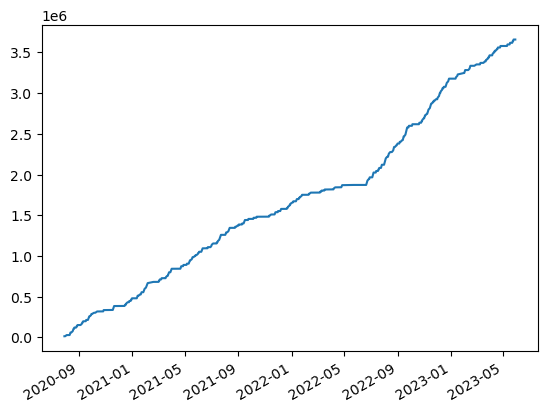

In [54]:
# calculate cumulative pnl
cum_pnl = pnl.cumsum()
cum_pnl.plot()
# calculate sharpe ratio
sharpe_ratio = (pnl.mean() / pnl.std()) * np.sqrt(252)
print(sharpe_ratio)

In [58]:
import pandas as pd
from step4_model_testing.model_testing import *

path = '/Users/jeremy_gp/Documents/GitHub/SummerIndependentProject/factors_data/'
symbol = 'EHF'
data = pd.read_csv(path + '{}_factors.csv'.format(symbol), index_col=0)
data.index = pd.to_datetime(data.index)
data['delta_1'] = data['spread'].diff().shift(-1)
data = data.loc['2020-09-02':]
# lists = ['spread', 'RSI', 'MACD', 'MACDhist','EMA_5', 'MA_5']
lists = ['spread', 'RSI']
data = test_logistic(data, lists, pd.to_datetime('2020-09-02 09:05:00'), 20, 1, symbol, 'RSI',0.8, 0.2)
data.index = pd.to_datetime(data.index)
data

/Users/jeremy_gp/Documents/GitHub/SummerIndependentProject/step4_model_testing/model_testing.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_test_preds = pd.Series()


2020-10-06 09:05:00   -1
2020-10-06 09:10:00   -1
2020-10-06 09:15:00   -1
2020-10-06 09:20:00   -1
2020-10-06 09:25:00   -1
                      ..
2023-06-29 12:35:00   -1
2023-06-29 12:45:00    1
2023-06-29 12:55:00   -1
2023-06-29 13:05:00   -1
2023-06-29 13:25:00    1
Length: 12415, dtype: int64


,spread,signal
2020-09-02 09:05:00,0.037174,NaN
2020-09-02 09:10:00,0.034141,NaN
2020-09-02 09:15:00,0.032345,NaN
2020-09-02 09:20:00,0.010758,NaN
2020-09-02 09:25:00,-0.002053,NaN
...,...,...
2023-06-30 13:05:00,-0.004077,NaN
2023-06-30 13:10:00,-0.002564,NaN
2023-06-30 13:15:00,-0.002856,NaN
2023-06-30 13:20:00,-0.002471,NaN


In [59]:
# find the value with index '2022-09-02 09:05:00' and
signal = data['signal']
signal['2022-09-02 09:05:00']

nan

In [64]:
pnl_daily_with_model = {}
# stockDataDate = stockData[stockData.date == date]
# futuresDataDate = futuresData[futuresData.date == date]
for date in tqdm(dates[20:707]):

    train_date = valid_date_n_days_before2(date, dates, 20)
    end_date = valid_date_n_days_later2(date, dates, 1)
    start_time = date + pd.DateOffset(hours=9)
    spread_historical_data = spread_df[train_date:date]
    sd = np.std(spread_historical_data['spread'], axis=0)
    mean = spread_historical_data['spread'].mean()
    upper = mean + 1.5 * sd
    lower = mean - 1.5 * sd

    stock_trade_data = stockData[start_time:end_date]
    future_trade_data = futuresData[start_time:end_date]
    # position 1 for long spread, -1 for short spread, 0 for no position
    position = 0
    # net position in dollar
    net_position = 0
    # shares of stock
    stock_position = 0
    # shares of future
    future_position = 0
    timestamp = start_time + pd.DateOffset(minutes=5)
    while timestamp <= stock_trade_data.index[-1]:
        # print(timestamp)
        if timestamp >= stock_trade_data.index[-1] or timestamp >= future_trade_data.index[-1]:
            # print(net_position, stock_position, future_position)
            stock_row = stock_trade_data.iloc[-1]
            future_row = future_trade_data.iloc[-1]
            if position == 1:
                net_position = net_position - stock_position * stock_row.SP1 + future_position * future_row.bidPrice1 * 2
            if position == -1:
                net_position = net_position + stock_position * stock_row.BP1 - future_position * future_row.askPrice1 * 2
            break
        row = stock_trade_data.loc[stock_trade_data.index >= timestamp].iloc[0]
        stock_mid_quote = (row['SP1'] + row['BP1']) / 2

        future_next_row = (future_trade_data.loc[future_trade_data.index > timestamp]).iloc[0]
        try:
            future_last_row = (future_trade_data.loc[future_trade_data.index <= timestamp]).iloc[-1]
            future_mid_quote = (future_last_row['askPrice1'] + future_last_row['bidPrice1']) / 2
            spread = np.log(stock_mid_quote) - np.log(future_mid_quote)
        except:
            timestamp = future_next_row.name
            continue
        # print(timestamp)
        if stock_position == 0 and future_position == 0:
            # print(1)
            if spread >= upper:
                if position == 0:
                    if timestamp in signal.index:
                        if signal[timestamp] == 1:
                            timestamp = future_next_row.name
                            continue
                    position = 1
                    stock_position = stock_position - 2
                    future_position = future_position + 1
                    net_position = net_position - row['BP1'] * 2 + future_last_row['askPrice1'] * 1 * 2
                    timestamp = future_next_row.name
                    continue
                next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                # print(next_row.name)
                timestamp = next_row.name
            elif spread <= lower:
                # print(1.2)
                if position == 0:
                    if timestamp in signal.index:
                        if signal[timestamp] == -1:
                            timestamp = future_next_row.name
                            continue
                    position = -1
                    stock_position = stock_position + 2
                    future_position = future_position - 1
                    net_position = net_position + row['SP1'] * 2 - future_last_row['bidPrice1'] * 1 * 2
                    timestamp = future_next_row.name
                    continue
                next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                # print(next_row.name)
                timestamp = next_row.name
            else:
                # print(1.3)
                next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                # print(next_row.name)
                timestamp = next_row.name
        else:
            # print(2)
            # print(position)
            if position == 1:

                if spread <=mean:
                    net_position = net_position + row['SP1'] * (0 - stock_position)
                    net_position = net_position - future_next_row['bidPrice1'] * future_position * 2
                    stock_position = 0
                    future_position = 0
                    timestamp = future_next_row.name
                    if timestamp >= future_trade_data.index[-1] or timestamp >= stock_trade_data.index[-1]:
                        break
                    row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                    timestamp = row.name
                    position = 0
                    if future_trade_data.index[-1] >= timestamp:
                        future_next_row = (future_trade_data.loc[future_trade_data.index >= timestamp]).iloc[0]
                    else:
                        timestamp = future_trade_data.index[-1]
                else:
                    next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                    timestamp = next_row.name
            elif position == -1:
                if spread >=mean:
                    net_position = net_position - row['BP1'] * stock_position
                    net_position = net_position + future_next_row['askPrice1'] * (0 - future_position) * 2
                    stock_position = 0
                    future_position = 0
                    timestamp = future_next_row.name
                    if timestamp >= future_trade_data.index[-1] or timestamp >= stock_trade_data.index[-1]:
                        break
                    row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                    timestamp = row.name
                    position = 0
                    if future_trade_data.index[-1] >= timestamp:
                        future_next_row = (future_trade_data.loc[future_trade_data.index >= timestamp]).iloc[0]
                    else:
                        timestamp = future_trade_data.index[-1]

                else:
                    next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                    timestamp = next_row.name
            else:
                next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                timestamp = next_row.name
    pnl_daily_with_model[date] = net_position

# plot pnl
pnl_with_model = pd.Series(pnl_daily_with_model)
print(pnl_with_model)

100%|██████████| 687/687 [00:15<00:00, 43.79it/s]

2020-07-29    14099.060126
2020-07-30      262.546564
2020-07-31      159.934343
2020-08-03    13876.428571
2020-08-04        0.000000
                  ...     
2023-05-23    20045.922468
2023-05-24        0.000000
2023-05-25    19977.114900
2023-05-26       93.645974
2023-05-29       29.583333
Length: 687, dtype: float64


10.928551494890215


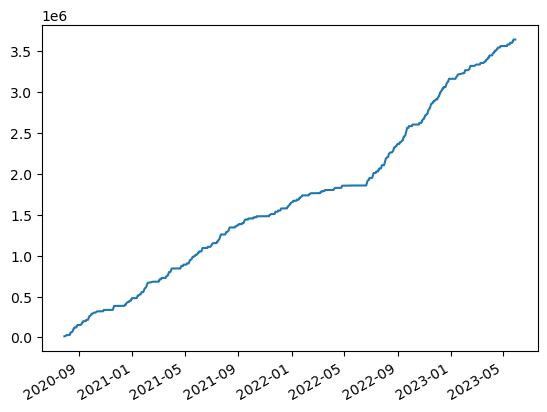

In [67]:
# calculate cumulative pnl
cum_pnl2 = pnl_with_model.cumsum()
cum_pnl2.plot()
# calculate sharpe ratio
sharpe_ratio2 = (pnl_with_model.mean() / pnl_with_model.std()) * np.sqrt(252)
print(sharpe_ratio2)

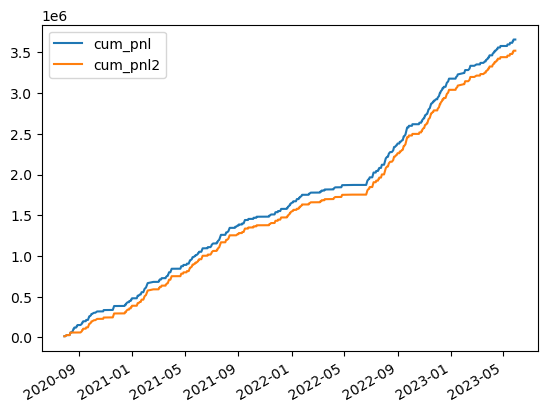

In [62]:
# draw cum_pnl and cum_pnl2 in one graph
cum_pnl.plot()
cum_pnl2.plot()
plt.legend(['cum_pnl', 'cum_pnl2'])
plt.show()

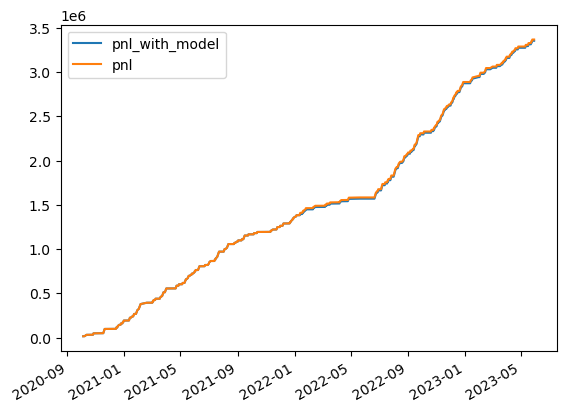

In [66]:
# concate two pnl into one dataframe
pnl_df = pd.concat([pnl_with_model, pnl], axis=1)
pnl_df = pnl_df.loc[pnl_df.index >= '2020-10-01']
# calculate cumulative pnl after 2020-06-01
cum_pnl_df = pnl_df.cumsum()
# plot pnl after 2020-06-01
cum_pnl_df.plot()
plt.legend(['pnl_with_model', 'pnl'])
plt.show()